# Image Classifier v2
This notebook serves as my attempt at implementing deep learning to determine not only whether an image is cloudy, but also to determine (with some measure of accuracy) the number of cloudy pixels in an image.

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

## Theory
The theory behind this neural network is outlined in a 2017 paper that serves as a written form of a presentation at the 8th International Conference of Pattern Recognition Systems, given in Madrid, Spain. The paper can be found in French archives (as the authors are all French, at French institutions) here: https://hal.archives-ouvertes.fr/hal-01783857/document. The paper is entitled *Deep learning for cloud detection*.

As a general overview the theory is to apply the CNN to individual pixels, rather than an image as a whole. In Image Classifier v1 I aimed simply to use resnet34 to classify if an image was cloudy or not. Here I define a custom network (CloudNet) originally designed to be in the same structure as the network outlined in the paper on page 7.

32x32 patches of an image surrounding a central pixel are passed to a neural network which attempts to learn how to classify the central pixel from the features that appear in the patch. This requires more work than my previous efforts, as it requires the entire image to have a "cloud mask" which indicates whether a pixel is part of a cloud or not. I expand upon this in more detail below.

CloudNet is defined as a multi layer neural network that takes a 32x32x3 input patch, where the three channels are RGB. This patch is convoled with a 5x5 convolution filter to a 32x32 image with 64 channels, which then is pooled to a 16x16x64 patch. This is again convolved with a 5x5 filter, but remains at 64 channels. It is then pooled again, convolved once more, then pooled. The result is a 4x4 patch with 64 channels. This is linearized and reduced from 1024 parameters down to 384, then 192, and then the output 2. In the classification scheme, 1 reprsents a pixel that is a cloud, and 0 represents a non-cloud pixel.

#### Alternative Methods
An alternative convolutional neural network for finding clouds was proposed in a 2018 paper, *Deep learning based cloud detection for medium and high resolution remote sensing images of different sensors*, which can be found here: https://arxiv.org/pdf/1810.05801.pdf. This network is vastly more complicated, although according to the paper, much more accurate. I provide it here as a possible future outlet of exploration.

## Pitfalls
Both of these algorithms were originally designed for satellite imagery of the Earth. Time will tell how accurate they are for pictures of the sky, arguably the exact opposite.

In [3]:
class CloudNet(nn.Module):

    def __init__(self):
        super(CloudNet, self).__init__()
        # 3 input channels (RGB), 64 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        # Pools the 32x32 patch down to 16x16
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        # Pools to 8x8
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        # Pools to 4x4
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Linear operations
        # First input should be 64 channels in 4x4 "images" due to the triple pooling.
        self.fc1 = nn.Linear(64 * 4 * 4, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 2)
        # 2 outputs, 1=cloud, 0=not

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        # view essentially resizes a tensor, -1 means it'll infer that dimension
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

I believe a major benefit in using a CNN this way presents itself readily in it's flexibility. In simply classifying an image as "cloudy" or "non-cloudy" the network is restricted to the 0.3s images alone, and would have to be greatly modified to fit the 6s images. By analyzing on a pixel level, I believe that the same network can be retrained on the 6s image dataset, and that the only change to the resulting network will be the weights of the underlying parameters. 

A further plus is given in that this allows us to determine the exact cloudiness of an image by simply running it through the network. On a GPU this would be a trivial amount of time. This should vastly improve on the previous method of determinig "cloudiness," which used only the brightness of a pixel and could thus only be applied to 0.3s images. It may also misidentify pixels in much greater numbers, due to fluctuations in night sky brightness and camera effects. That, in turn, could strenghthen the correlation with the fraction of the night the dome is closed. The network could be expanded to predict this directly, although that is optimistic. This, of course, all assuming that this network actually works, and I haven't written this fun explanation for nothing :). Quite honestly, I'm writing all of this after defining the network and confirming that it works on a (1,3,32,32) tensor, but without actually running an image through it. 

In theory, since you could use the network on the entire night you'd know how many pixels over the entire night are clouds, and how many are not, and you'd know the fraction of that night that the dome was closed. You could add this as another layer in the network. In theory.

In [4]:
import os
import numpy as np
from PIL import Image
import mask

The following code creates a list of pixels to run through the network. It uses a full mask, which sets all pixels ourside the circular image to 1, and all the pixels inside that are not horizon objects to 0. These pixels set to 0 are the ones we want to analyze. We need to ensure also that the pixels are at least 16 pixels from the edges of the image since we analyze 32x32 patches surrounding each pixel we are analyzing.

In [5]:
# The center of the image.
center = (256, 252)

pixels = []

msk = mask.generate_full_mask(True)
# We need to save the full mask since generate_full_mask doesn't save the mask.
mask.save_mask(msk)
loc = os.path.join('Images', 'Mask.png')
img = np.asarray(Image.open(loc).convert('L'))

for row in range(0, img.shape[0]):
    for column in range(0, img.shape[1]):
        if img[row, column] == 0 and row > 16 and column > 16 and row < 496 and column < 496:
            pixels.append([row, column])

Saved: Images/Mask.png
Saved: Images/Mask.png


We here define a Dataset object that loads an image and then creates 32x32 patches surrounding each pixel that will be analyzed in the network. It additionally loads a binary image where the cloud pixels are set to 1 and the non cloud images are set to 0. This image is used to determine the label for each 32x32 patch.

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [7]:
class PixelDataset(Dataset):
    def __init__(self, name, pixels, transform=None):
        self.name = name
        self.pixels = pixels
        self.transform = transform

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        # This one loads the image itself
        # https://github.com/python-pillow/Pillow/issues/835
        # Thanks to https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py
        # For this solution.
        loc = os.path.join('Images', *['data', 'train', 'new', self.name])
        with open(loc, 'rb') as f:
            im = np.asarray(Image.open(f).convert('RGB'))
        
        # This one loads the binary image that contains pixel labels
        loc = os.path.join('Images', *['data', 'labels', self.name])
        with open(loc, 'rb') as f:
            labelim = np.asarray(Image.open(f).convert('L'))
        # The following line converts the image to binary 1,0
        labelim = np.where(labelim == 255, 1, 0)
        
        # This gets what position we're looking at from the pixels array
        pos = self.pixels[index]
        
        # Slices out the section of the image
        # Transposes to be in the correct shape for torch tensoring.
        patch = im[pos[0]-16:pos[0]+16,pos[1]-16:pos[1]+16]
        #patch = patch.transpose((2,0,1))
        #patch = torch.from_numpy(patch)
        #patch = patch.float() # Cast to float type for network.
        
        # Gets the label
        label = labelim[pos[0], pos[1]]
        
        # Return a Tuple!
        if self.transform:
            patch = self.transform(patch)

        return (patch, label)

Need to define the transformations that turn the numpy patches into a tensor and then normalize them so that the mean is roughly 0.5. This ensures that rather than ranging from 0-255 the pixel values range roughly from 0 to 1. This increases the accuracy of the network.

In [8]:
# Transforms the images into a nice format.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Transformation object, converts to a tensor then normalizes.
trans = transforms.Compose([transforms.ToTensor(), normalize])

In [9]:
data = PixelDataset('r_ut073249s57180.png', pixels, transform=trans)
trainloader = DataLoader(data, batch_size=50, shuffle=False, num_workers=4)

In [10]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cpu


This is the training method. It runs through the data, loads, finds the loss, and back propagates it. It prints the average loss for each individual batch after 50 batches. This should be pretty straightforward.

In [9]:
def train(loader, net, crit, opt, lr):
    
    running_loss = 0.0
    for i, batch in enumerate(loader, 0):
        
        # Get the input with their true labels
        inputs, labels = batch
        
        # If we have a GPU this shifts labels and inputs onto it.
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zeros the optimzer
        opt.zero_grad()

        # Get the predicted labels and find the loss by comparing
        outputs = net(inputs)
        loss = crit(outputs, labels)
        
        # Propagate the loss backwards
        loss.backward()
        opt.step()

        # Prints every 50 batches (Batch size currently 50, so every 2500 patches)
        running_loss += loss.item()
        if i % 50 == 49:
            print(running_loss)
            print('[%d, %5d] Avg. loss: %.3f' % (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

Define the network, the loss criterion, and the optimizer. I originally used a learning rate of 0.01, but that lead to an exploding gradient which would eventually culminate in many of the parameters rising up to be inf or nan. Reducing the global learning rate by a factor of ten solves this problem.

In [10]:
global_lr = 0.001
net = CloudNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=global_lr, momentum=0.9)

Currently trains for two epochs, and technically only actually trains on a single image, which has something like 170,000 pixel patches. At present, anyway. 

In [11]:
for epoch in range(2):
    train(trainloader, net, criterion, optimizer, lr=global_lr)

print('Finished Training')

21.702518546953797
[1,    50] Avg. loss: 0.434
0.0763372658911976
[1,   100] Avg. loss: 0.002
0.007677087756746914
[1,   150] Avg. loss: 0.000
0.5932049435796216
[1,   200] Avg. loss: 0.012
6.959521498341928
[1,   250] Avg. loss: 0.139
13.420562566258013
[1,   300] Avg. loss: 0.268
31.329120349138975
[1,   350] Avg. loss: 0.627
15.48062838288024
[1,   400] Avg. loss: 0.310
9.4654719135724
[1,   450] Avg. loss: 0.189
5.4548792181303725
[1,   500] Avg. loss: 0.109
4.781893578823656
[1,   550] Avg. loss: 0.096
4.323571750428528
[1,   600] Avg. loss: 0.086
4.4150537091773
[1,   650] Avg. loss: 0.088
4.56357005238533
[1,   700] Avg. loss: 0.091
4.467688464093953
[1,   750] Avg. loss: 0.089
4.372548872604966
[1,   800] Avg. loss: 0.087
5.341641454375349
[1,   850] Avg. loss: 0.107
5.7558949190424755
[1,   900] Avg. loss: 0.115
4.699652400566265
[1,   950] Avg. loss: 0.094
4.551505705399904
[1,  1000] Avg. loss: 0.091
3.2589515046565793
[1,  1050] Avg. loss: 0.065
3.923074229445774
[1,  1100]

Once the network is trained and initiliazed, we can predict. The next cell predicts the image loaded into the valloader. It finds the accuracy and prints the total number of pixel patches. Following that we turn the array of predictions (preds) into a two dimensional binary image, where 1 represents a cloud pixel and 0 represents and non cloud pixel. Finally we then plot the two side by side to see how we did. 

In [21]:
data2 = PixelDataset('r_ut041252s80160.png', pixels, transform=trans)
valloader = DataLoader(data2, batch_size=50, shuffle=False, num_workers=4)

In [22]:
# The array of predictions.
preds = np.asarray([])

correct = 0
total = 0

# 
for data in valloader:
    # The true labels and image data
    inputs, labels = data
    
    # If we have a GPU this shifts labels and inputs onto it.
    inputs = inputs.to(device)
    labels = labels.to(device)
        
    # Gets the predicted labels
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
        
    # Adds to the total the number of labels here (should be equal to batch size)
    total = total + labels.size(0)
        
    # If the predicted label is the same as the true label increment correct by 1
    # This line checks all 50 patches in the batch at once.
    correct += (predicted == labels).sum().item()
        
    preds = np.concatenate((preds, predicted.to('cpu').numpy()))

accuracy = correct / total * 100
print('Total pixels analyzed: ' + str(total))
print('Accuracy: '  + str(accuracy) + '%')

Total pixels analyzed: 169806
Accuracy: 88.53750750856861%


In [23]:
preds2 = np.zeros((512,512))
for i, loc in enumerate(pixels):
    preds2[loc[0], loc[1]] = preds[i]

name = 'r_ut041252s80160.png'
loc = os.path.join('Images', *['data', 'train', 'new', name])
loc2 = os.path.join('Images', *['data', 'labels', name])

with open(loc2, 'rb') as f:
    labelim = np.asarray(Image.open(f).convert('L'))

with open(loc, 'rb') as f:
    realim = np.asarray(Image.open(f).convert('L'))

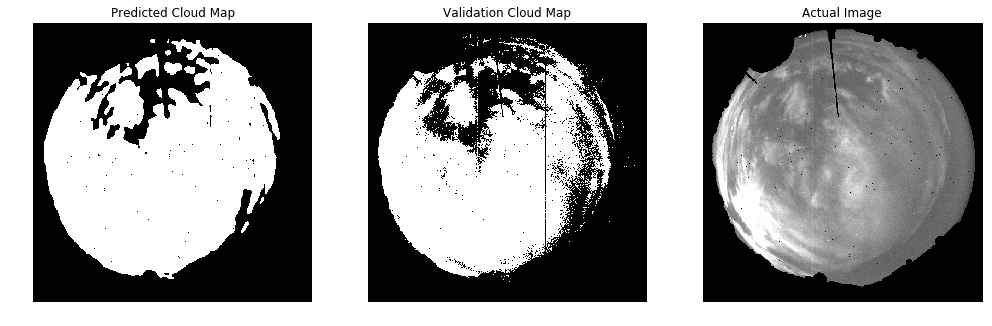

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3)
ax[0].imshow(preds2, cmap='gray')
ax[0].set_title('Predicted Cloud Map')
ax[1].imshow(labelim, cmap='gray')
ax[1].set_title('Validation Cloud Map')
ax[2].imshow(realim, cmap='gray')
ax[2].set_title('Actual Image')

fig.set_size_inches(17, 8)
for a in ax:
    a.set_axis_off()